In [1]:
from pandas import read_csv
import pandas as pd
import numpy as np
import os
# os.environ['USE_PYGEOS'] = '0'
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import shapely.wkt
import geopandas as gpd
import contextily as cx
# import constants as c
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')

os.chdir('C:\SynthFirm')

In [2]:
# define scenario
scenario_name = 'national'
input_dir = 'inputs_' + scenario_name
output_dir = 'outputs_' + scenario_name
plot_dir = 'plots_' + scenario_name
region_code = [411, 531, 532, 539]
# region_code = [62, 64, 65, 69]
focus_region = 531
lehd_file = 'US_naics.csv'
map_file = scenario_name + '_freight.geojson'

In [3]:
synthfirm_all = read_csv(os.path.join(output_dir, 'synthetic_firms_v2.csv'))
region_map = gpd.read_file(os.path.join(input_dir, map_file))
mesozone_id_lookup = read_csv(os.path.join(input_dir, 'zonal_id_lookup_final.csv'))
lehd_validation = read_csv(os.path.join(input_dir, lehd_file))
synthfirm_output = read_csv(os.path.join(output_dir, 'processed_b2b_flow_summary_mesozone.csv'))

# calculate land area
region_map.dropna(subset = ['geometry'], inplace = True)
region_map.loc[:, "area"] = \
region_map['geometry'].to_crs({'proj':'cea'}).map(lambda p: p.area / 10**6) 
region_map.head(5)

,GEOID,FAFID,MESOZONE,CBPZONE,geometry,area
0,010810404004,19,010810404004,01081,"MULTIPOLYGON (((-85.50516 32.56049, -85.50480 ...",2.261917
1,010810414002,19,010810414002,01081,"MULTIPOLYGON (((-85.38802 32.63300, -85.38751 ...",0.649339
2,010810404003,19,010810404003,01081,"MULTIPOLYGON (((-85.48902 32.58480, -85.48640 ...",3.087215
3,010810414003,19,010810414003,01081,"MULTIPOLYGON (((-85.38805 32.63065, -85.38659 ...",0.841311
4,010810409012,19,010810409012,01081,"MULTIPOLYGON (((-85.50423 32.64247, -85.50367 ...",4.583590


In [4]:
print(synthfirm_all.columns)
industries = synthfirm_all.Industry_NAICS6_Make.unique()
print(len(industries))
firm_by_zone = synthfirm_all.groupby(['MESOZONE']).agg({'BusID':'count',
                                                       'Emp':'sum'})
firm_by_zone = firm_by_zone.reset_index()
firm_by_zone.columns = ['MESOZONE', 'firm_count', 'employment_count']
firm_by_zone.head(5)

print(firm_by_zone[['firm_count', 'employment_count']].sum())
firm_by_zone = pd.merge(firm_by_zone, mesozone_id_lookup, 
                        on = 'MESOZONE', how = 'left')
firm_by_zone.head(5)

Index(['CBPZONE', 'FAFZONE', 'esizecat', 'Industry_NAICS6_Make',
       'Commodity_SCTG', 'Emp', 'BusID', 'MESOZONE', 'ZIPCODE'],
      dtype='object')
423
firm_count          8.418623e+06
employment_count    1.471677e+08
dtype: float64


,MESOZONE,firm_count,employment_count,GEOID,FAFID,CBPZONE,FAFNAME
0,10010201001,10,94.229782,10010201001,19,1001,Rest of AL
1,10010202001,13,250.705115,10010202001,19,1001,Rest of AL
2,10010202002,68,1183.101922,10010202002,19,1001,Rest of AL
3,10010203001,12,53.209971,10010203001,19,1001,Rest of AL
4,10010203002,30,173.821327,10010203002,19,1001,Rest of AL


In [5]:
# get synthetic firms by county
firm_by_zone_county = firm_by_zone.groupby('CBPZONE')[['employment_count']].sum()
firm_by_zone_county = firm_by_zone_county.reset_index()
firm_by_zone_county.head(5)

mesozone_id_lookup_short = mesozone_id_lookup[['MESOZONE', 'GEOID']]
emp_by_cbg = firm_by_zone.groupby('MESOZONE')[['employment_count']].sum()
emp_by_cbg = emp_by_cbg.reset_index()
emp_by_cbg = pd.merge(emp_by_cbg,
                      mesozone_id_lookup_short,
                      on = 'MESOZONE', how = 'left')
emp_by_cbg.head(5)

,MESOZONE,employment_count,GEOID
0,10010201001,94.229782,10010201001
1,10010202001,250.705115,10010202001
2,10010202002,1183.101922,10010202002
3,10010203001,53.209971,10010203001
4,10010203002,173.821327,10010203002


In [6]:
# compare to LEHD data
lehd_validation.head(5)
print(lehd_validation.columns)

list_of_attr = ['n11', 'n21', 'n22', 'n23', 'n3133', 'n42',
                'n4445', 'n4849', 'n51', 'n52', 'n53', 'n54', 
                'n55', 'n56', 'n61', 'n62', 'n71', 'n72', 'n81', 'n92']
lehd_validation = pd.merge(lehd_validation,mesozone_id_lookup,
                               on = 'GEOID', how = 'left')
lehd_validation.loc[:, 'total'] = lehd_validation.loc[:, list_of_attr].sum(axis = 1)
lehd_validation.head(5)


Index(['GEOID', 'n11', 'n21', 'n22', 'n23', 'n3133', 'n42', 'n4445', 'n4849',
       'n51', 'n52', 'n53', 'n54', 'n55', 'n56', 'n61', 'n62', 'n71', 'n72',
       'n81', 'n92'],
      dtype='object')


,GEOID,n11,n21,n22,n23,n3133,n42,n4445,n4849,n51,...,n62,n71,n72,n81,n92,FAFID,MESOZONE,CBPZONE,FAFNAME,total
0,10010201001,0,0,0,30,0,0,10,1,0,...,0,0,8,8,0,19,10010201001,1001,Rest of AL,215
1,10010202001,0,0,0,0,0,0,4,210,0,...,0,0,0,0,0,19,10010202001,1001,Rest of AL,445
2,10010202002,0,0,41,30,21,6,50,46,0,...,26,0,55,14,618,19,10010202002,1001,Rest of AL,1105
3,10010203001,0,0,0,4,0,7,0,0,0,...,29,0,0,21,0,19,10010203001,1001,Rest of AL,74
4,10010203002,8,0,0,0,0,0,178,0,3,...,323,14,21,8,25,19,10010203002,1001,Rest of AL,700


142554479
147167092.81045732
7042.8 1.0


,County,LEHD employment,SynthFirm employment
0,1001,12169,13228.0
1,1003,71849,73486.0
2,1005,7842,7839.0
3,1007,4039,4088.0
4,1009,8307,8401.0


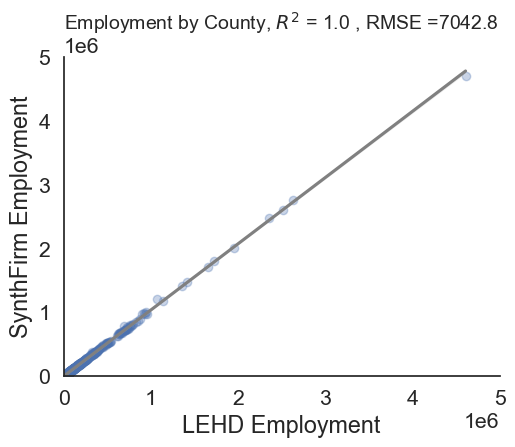

In [7]:
lehd_firm_by_county = lehd_validation.groupby('CBPZONE')[['total']].sum()
lehd_firm_by_county = lehd_firm_by_county.reset_index()
# # print(lehd_firm_by_county.head(5))
firm_comparison_by_county = pd.merge(lehd_firm_by_county, 
                                     firm_by_zone_county,
                                     on = 'CBPZONE',
                                     how = 'inner')
firm_comparison_by_county.columns = ['County', 'LEHD employment', 'SynthFirm employment']
rmse_emp = mean_squared_error(firm_comparison_by_county['LEHD employment'], 
                              firm_comparison_by_county['SynthFirm employment'], squared = False)
r2_emp = r2_score(firm_comparison_by_county['LEHD employment'], 
                  firm_comparison_by_county['SynthFirm employment'])
rmse_emp = np.round(rmse_emp, 1)
r2_emp = np.round(r2_emp, 2)
print(firm_comparison_by_county['LEHD employment'].sum())
print(firm_comparison_by_county['SynthFirm employment'].sum())
print(rmse_emp, r2_emp)
plt.style.use('seaborn-v0_8-white')
# plt.rcParams['axes.facecolor'] = 'white'
sns.set(font_scale=1.4)  # crazy big
sns.set_style("white")
sns.lmplot(
    data=firm_comparison_by_county,
    x="LEHD employment", y="SynthFirm employment", 
    height=4.5, aspect = 1.2, line_kws={'color': 'grey'}, 
    scatter_kws = {'alpha':0.3})
# g.set_facecolor("white")

plt.xlim([0, 5000000])
plt.ylim([0, 5000000])
plt.xlabel('LEHD Employment')
plt.ylabel('SynthFirm Employment')
plt.title('Employment by County, $R^{2}$ = ' + str(r2_emp) + \
          ' , RMSE =' + str(rmse_emp), fontsize = 14)
plt.savefig(os.path.join(plot_dir, 'emp_by_county_validation.png'), dpi = 200,
           bbox_inches = 'tight')

firm_comparison_by_county.head(5)

142220088
147167092.81045732
1030.4 0.76


,GEOID,LEHD employment,SynthFirm employment
0,10010201001,215,94.229782
1,10010202001,445,250.705115
2,10010202002,1105,1183.101922
3,10010203001,74,53.209971
4,10010203002,700,173.821327


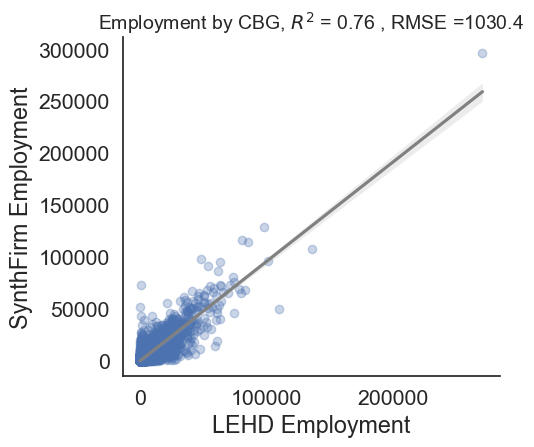

In [8]:
# compare results by CBG
lehd_firm_by_cbg = lehd_validation.groupby('GEOID')[['total']].sum()
lehd_firm_by_cbg = lehd_firm_by_cbg.reset_index()
# # print(lehd_firm_by_county.head(5))
emp_by_cbg.drop(columns = 'MESOZONE', inplace = True)
firm_comparison_by_cbg = pd.merge(lehd_firm_by_cbg, 
                                     emp_by_cbg,
                                     on = 'GEOID',
                                     how = 'inner')
firm_comparison_by_cbg.columns = ['GEOID', 'LEHD employment', 'SynthFirm employment']
rmse_emp = mean_squared_error(firm_comparison_by_cbg['LEHD employment'], 
                              firm_comparison_by_cbg['SynthFirm employment'], squared = False)
r2_emp = r2_score(firm_comparison_by_cbg['LEHD employment'], 
                  firm_comparison_by_cbg['SynthFirm employment'])
rmse_emp = np.round(rmse_emp, 1)
r2_emp = np.round(r2_emp, 2)
print(firm_comparison_by_cbg['LEHD employment'].sum())
print(firm_comparison_by_cbg['SynthFirm employment'].sum())
print(rmse_emp, r2_emp)
plt.style.use('seaborn-v0_8-white')
# plt.rcParams['axes.facecolor'] = 'white'
sns.set(font_scale=1.4)  # crazy big
sns.set_style("white")
sns.lmplot(
    data=firm_comparison_by_cbg,
    x="LEHD employment", y="SynthFirm employment", 
    height=4.5, aspect = 1.2, line_kws={'color': 'grey'}, 
    scatter_kws = {'alpha':0.3})
# g.set_facecolor("white")

# plt.xlim([0, 1300000])
# plt.ylim([0, 1300000])
plt.xlabel('LEHD Employment')
plt.ylabel('SynthFirm Employment')
plt.title('Employment by CBG, $R^{2}$ = ' + str(r2_emp) + \
          ' , RMSE =' + str(rmse_emp), fontsize = 14)
plt.savefig(os.path.join(plot_dir, 'emp_by_CBG_validation.png'), dpi = 200,
           bbox_inches = 'tight')

firm_comparison_by_cbg.head(5)

142554479
147167744.81045714
['11' '23' '33' '42' '44' '45' '48' '49' '4A' '52' '53' '61' '62' '71'
 '72' '81' 'S0' '51' '54' '56' '21' '22' '31' '32' '55']


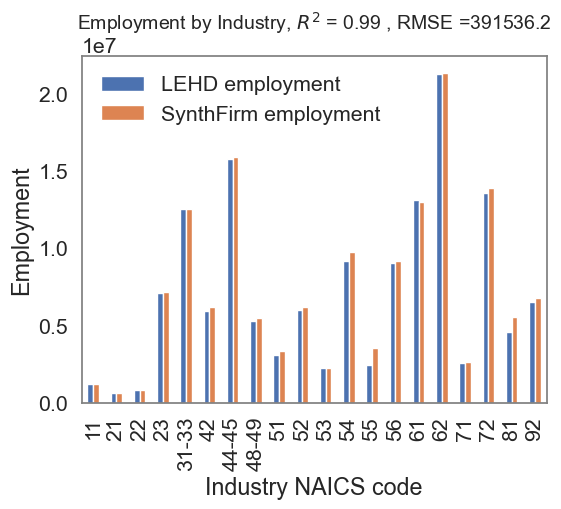

In [9]:
# compare to LEHD data
#lehd_validation.head(5)
industry_lookup = {'11':'11', '21':'21', '22':'22', '23':'23',
                   '31':'31-33', '32':'31-33', '33':'31-33',
                   '42':'42', '44':'44-45', '45':'44-45', '4A': '44-45',
                   '48':'48-49', '49':'48-49', '51':'51',
                   '52':'52', '53':'53', '54':'54', '55':'55',
                   '56':'56', '61':'61', '62':'62', '71':'71',
                   '72':'72', '81':'81', '92':'92', 'S0': '92'}
selected_counties = firm_comparison_by_county.County.unique()
lehd_firm_by_industry = pd.melt(lehd_validation, id_vars = 'CBPZONE',
                               value_vars=list_of_attr, 
                                var_name='industry', value_name='emp')

lehd_firm_by_industry = lehd_firm_by_industry.reset_index()
lehd_firm_by_industry.loc[:, 'industry'] = \
lehd_firm_by_industry.loc[:, 'industry'].str.split('n').str[1]

lehd_firm_by_industry.loc[lehd_firm_by_industry['industry'] == '3133', 'industry'] = '31-33'
lehd_firm_by_industry.loc[lehd_firm_by_industry['industry'] == '4445', 'industry'] = '44-45'
lehd_firm_by_industry.loc[lehd_firm_by_industry['industry'] == '4849', 'industry'] = '48-49'
lehd_firm_by_industry = \
lehd_firm_by_industry.loc[lehd_firm_by_industry['CBPZONE'].isin(selected_counties)]


lehd_firm_by_industry = lehd_firm_by_industry.groupby(['industry'])[['emp']].sum()
print(lehd_firm_by_industry['emp'].sum())
# lehd_firm_by_industry.head(5)
print(synthfirm_all.loc[:, 'Emp'].sum())
synthfirm_all.loc[:, 'Industry_NAICS6_Make'] = synthfirm_all.loc[:, 'Industry_NAICS6_Make'].astype(str)
synthfirm_all.loc[:, 'NAICS2'] = synthfirm_all.loc[:, 'Industry_NAICS6_Make'].str[:2]
print(synthfirm_all.loc[:, 'NAICS2'].unique())
synthfirm_all.loc[:, 'industry'] = synthfirm_all.loc[:, 'NAICS2'].map(industry_lookup)

firm_by_industry = synthfirm_all.groupby(['industry'])[['Emp']].sum()
# print(firm_in_study_area_by_industry['Emp'].sum())
firm_by_industry = firm_by_industry.reset_index()
firm_comparison_by_industry = pd.merge(lehd_firm_by_industry,
                                       firm_by_industry,
                                       on = 'industry', how = 'inner')

firm_comparison_by_industry.columns = ['Industry', 'LEHD employment',  'SynthFirm employment']
rmse_emp = mean_squared_error(firm_comparison_by_industry['LEHD employment'], 
                              firm_comparison_by_industry['SynthFirm employment'], squared = False)
r2_emp = r2_score(firm_comparison_by_industry['LEHD employment'], 
                  firm_comparison_by_industry['SynthFirm employment'])
rmse_emp = np.round(rmse_emp, 1)
r2_emp = np.round(r2_emp, 2)

# print(firm_comparison_by_industry['SynthFirm employment'].sum())
# print(firm_comparison_by_industry.head(5))
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_style("white")
sns.set(font_scale=1.4)  # crazy big
fig, ax = plt.subplots(figsize = (6,4.5))
ax.set(facecolor = "white")
firm_comparison_by_industry.plot(kind = 'bar',
    x="Industry", ax = ax)
plt.xlabel('Industry NAICS code')
plt.ylabel('Employment')
ax.spines['bottom'].set_color('0.5')
ax.spines['top'].set_color('0.5')
ax.spines['right'].set_color('0.5')
ax.spines['left'].set_color('0.5')
# plt.grid(color='gray')
# ax.patch.set_edgecolor('black')  

# ax.patch.set_linewidth(1)  
plt.title('Employment by Industry, $R^{2}$ = ' + str(r2_emp) + \
          ' , RMSE =' + str(rmse_emp), fontsize = 14)
plt.savefig(os.path.join(plot_dir, 'emp_by_industry_validation.png'), dpi = 200, 
            bbox_inches = 'tight')

# firm_in_study_area_by_industry

In [10]:
# firm_in_region = firm_by_zone.loc[firm_by_zone['FAFID'].isin([focus_region])]
firm_by_zone.loc[:, 'MESOZONE'] = \
firm_by_zone.loc[:, 'MESOZONE'].astype(np.int64)
region_map.loc[:, 'MESOZONE'] = \
region_map.loc[:, 'MESOZONE'].astype(np.int64)

region_map_with_firm = region_map.merge(firm_by_zone, on='MESOZONE', how='inner')
region_map_with_firm.loc[:, 'firm_per_area'] = \
region_map_with_firm.loc[:, 'firm_count'] / region_map_with_firm.loc[:, 'area']
region_map_with_firm.loc[:, 'emp_per_area'] = \
region_map_with_firm.loc[:, 'employment_count'] / region_map_with_firm.loc[:, 'area']
region_map_with_firm.head(5)

,GEOID_x,FAFID_x,MESOZONE,CBPZONE_x,geometry,area,firm_count,employment_count,GEOID_y,FAFID_y,CBPZONE_y,FAFNAME,firm_per_area,emp_per_area
0,010810404004,19,10810404004,01081,"MULTIPOLYGON (((-85.50516 32.56049, -85.50480 ...",2.261917,142,2305.220226,10810404004,19,1081,Rest of AL,62.778612,1019.144556
1,010810414002,19,10810414002,01081,"MULTIPOLYGON (((-85.38802 32.63300, -85.38751 ...",0.649339,6,672.341781,10810414002,19,1081,Rest of AL,9.240160,1035.424326
2,010810404003,19,10810404003,01081,"MULTIPOLYGON (((-85.48902 32.58480, -85.48640 ...",3.087215,23,356.272119,10810404003,19,1081,Rest of AL,7.450081,115.402439
3,010810409012,19,10810409012,01081,"MULTIPOLYGON (((-85.50423 32.64247, -85.50367 ...",4.583590,1,7.871465,10810409012,19,1081,Rest of AL,0.218170,1.717314
4,010810406031,19,10810406031,01081,"MULTIPOLYGON (((-85.52425 32.59608, -85.52324 ...",2.921087,27,738.430009,10810406031,19,1081,Rest of AL,9.243134,252.792883


In [11]:
from pygris.utils import shift_geometry

region_map_with_firm = shift_geometry(region_map_with_firm)

# us_rescaled.plot()

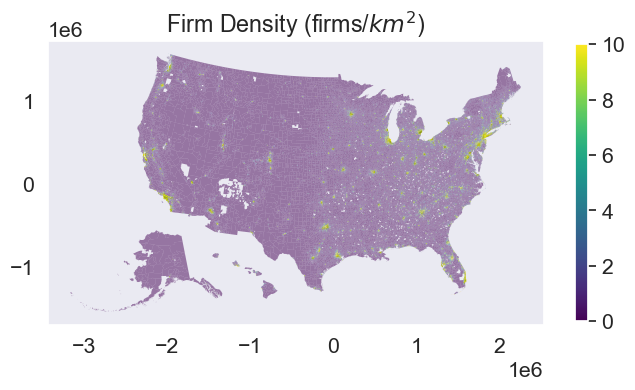

In [12]:
ax = region_map_with_firm.plot(figsize = (8,6), column = 'firm_per_area', 
                           vmin=0, vmax=10, alpha = 0.5, legend=True,
                              cmap='viridis',
                              linewidth=0.01, 
                            legend_kwds = {'shrink': 0.6}, edgecolor='none')
# cx.add_basemap(ax, crs = 'EPSG:4326', source = cx.providers.CartoDB.Positron)
# ax.set_xlim(-125,-62)
# ax.set_ylim(24,50)
ax.grid(False)
plt.title('Firm Density (firms/$km^{2}$)')
plt.savefig(os.path.join(plot_dir, 'region_firm_count.png'), dpi = 300)

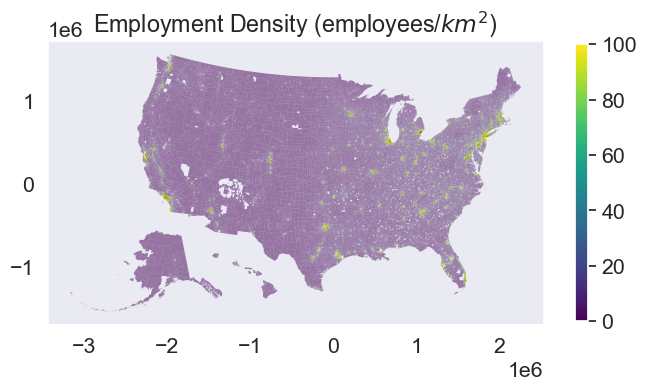

In [14]:
ax = region_map_with_firm.plot(figsize = (8,6), column = 'emp_per_area', 
                            vmin=0, vmax=100, alpha = 0.5, legend=True,
                               cmap='viridis',
                              linewidth=0.01, 
                            legend_kwds = {'shrink': 0.6}, edgecolor='none')
# cx.add_basemap(ax, crs = 'EPSG:4326',source = cx.providers.CartoDB.Positron)
plt.title('Employment Density (employees/$km^{2}$)')
# ax.set_xlim(-125,-62)
# ax.set_ylim(24,50)
ax.grid(False)
plt.savefig(os.path.join(plot_dir, 'region_emp_count.png'), dpi = 300)

In [15]:
# plot production
print(synthfirm_output.columns)
# production_in_region = synthfirm_output.loc[synthfirm_output['orig_FAFID'].isin([focus_region])]
production_in_region = synthfirm_output.groupby(['SellerZone'])[['ShipmentLoad']].sum()
production_in_region = production_in_region.reset_index()
production_in_region = production_in_region.rename(columns = {'SellerZone': 'MESOZONE'})
production_in_region['MESOZONE'] = \
production_in_region['MESOZONE'].astype(np.int64)
region_map_with_production = \
region_map.merge(production_in_region, on='MESOZONE', how='inner')
region_map_with_production.loc[:, 'production_per_area'] = \
region_map_with_production.loc[:, 'ShipmentLoad'] * 0.907185/ \
region_map_with_production.loc[:, 'area']
# sf_map_with_firm.loc[:, 'emp_per_area'] = sf_map_with_firm.loc[:, 'employment_count'] / sf_map_with_firm.loc[:, 'area']
region_map_with_production.head(5)

Index(['Unnamed: 0', 'SellerZone', 'orig_FAFID', 'orig_FAFNAME', 'BuyerZone',
       'dest_FAFID', 'dest_FAFNAME', 'Commodity_SCTG', 'SCTG_Group',
       'SCTG_Name', 'mode_choice', 'tmiles', 'ShipmentLoad', 'count',
       'outbound', 'inbound', 'Distance'],
      dtype='object')


,GEOID,FAFID,MESOZONE,CBPZONE,geometry,area,ShipmentLoad,production_per_area
0,010810406031,19,10810406031,01081,"MULTIPOLYGON (((-85.52425 32.59608, -85.52324 ...",2.921087,1.328729,0.412656
1,010810406042,19,10810406042,01081,"MULTIPOLYGON (((-85.54753 32.57396, -85.54722 ...",6.784977,47.633552,6.368842
2,010810402001,19,10810402001,01081,"MULTIPOLYGON (((-85.46446 32.61263, -85.46449 ...",2.542523,1.254192,0.447502
3,010810421023,19,10810421023,01081,"MULTIPOLYGON (((-85.38247 32.52156, -85.37913 ...",44.262082,13.168737,0.269903
4,010810418002,19,10810418002,01081,"MULTIPOLYGON (((-85.20430 32.73548, -85.20401 ...",48.704788,3.107936,0.057889


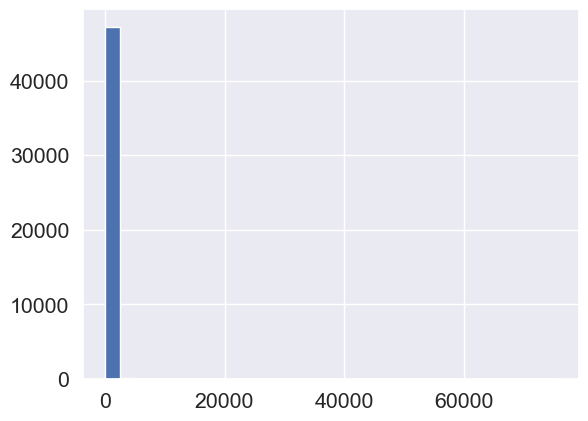

In [16]:
region_map_with_production['production_per_area'].hist(bins= 30)
region_map_with_production = shift_geometry(region_map_with_production)

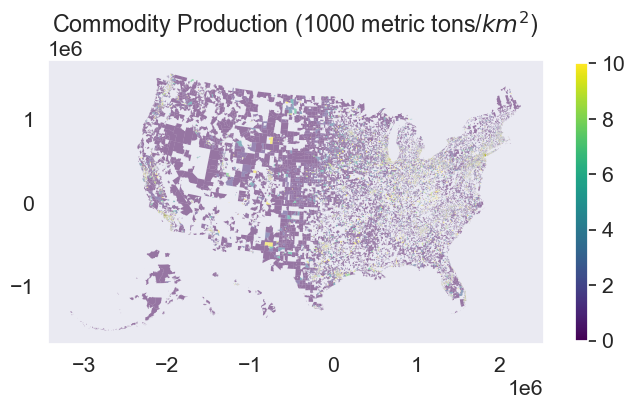

In [17]:
ax = region_map_with_production.plot(figsize = (8,6), column = 'production_per_area', 
                            alpha = 0.5, legend=True,
                            vmin = 0, vmax = 10,
                            # norm=matplotlib.colors.LogNorm(vmin=region_map_with_production.production_per_area.min(), 
                            #                                vmax=region_map_with_production.production_per_area.max()),
                            cmap='viridis',
                            linewidth=0.01, 
                            legend_kwds = {'shrink': 0.6})
# cx.add_basemap(ax, crs = 'EPSG:4326',source = cx.providers.CartoDB.Positron)

ax.grid(False)
plt.title('Commodity Production (1000 metric tons/$km^{2}$)')
plt.savefig(os.path.join(plot_dir, 'region_production_allmodes.png'), dpi = 300)

In [18]:
# print(synthfirm_output.columns)
# attraction_in_region = synthfirm_output.loc[synthfirm_output['dest_FAFID'].isin([focus_region])]
attraction_in_region = synthfirm_output.groupby(['BuyerZone'])[['ShipmentLoad']].sum()
attraction_in_region = attraction_in_region.reset_index()
attraction_in_region = attraction_in_region.rename(columns = {'BuyerZone': 'MESOZONE'})
attraction_in_region['MESOZONE'] = \
attraction_in_region['MESOZONE'].astype(np.int64)
region_map_with_attraction = \
region_map.merge(attraction_in_region, on='MESOZONE', how='inner')
region_map_with_attraction.loc[:, 'attraction_per_area'] = \
region_map_with_attraction.loc[:, 'ShipmentLoad'] * 0.907185/ \
region_map_with_attraction.loc[:, 'area']
region_map_with_attraction = shift_geometry(region_map_with_attraction)
# sf_map_with_firm.loc[:, 'emp_per_area'] = sf_map_with_firm.loc[:, 'employment_count'] / sf_map_with_firm.loc[:, 'area']
region_map_with_attraction.head(5)

,GEOID,FAFID,MESOZONE,CBPZONE,geometry,area,ShipmentLoad,attraction_per_area
0,010810404004,19,10810404004,01081,"MULTIPOLYGON (((978070.283 -498464.996, 978094...",2.261917,83.933268,33.663042
1,010810414002,19,10810414002,01081,"MULTIPOLYGON (((988039.942 -489215.485, 988078...",0.649339,0.363832,0.508306
2,010810404003,19,10810404003,01081,"MULTIPOLYGON (((979268.296 -495603.968, 979489...",3.087215,4.026290,1.183134
3,010810406031,19,10810406031,01081,"MULTIPOLYGON (((975861.269 -494716.046, 975911...",2.921087,61.725466,19.169719
4,010810420022,19,10810420022,01081,"MULTIPOLYGON (((1020404.054 -495462.987, 10206...",9.075258,0.708638,0.070837


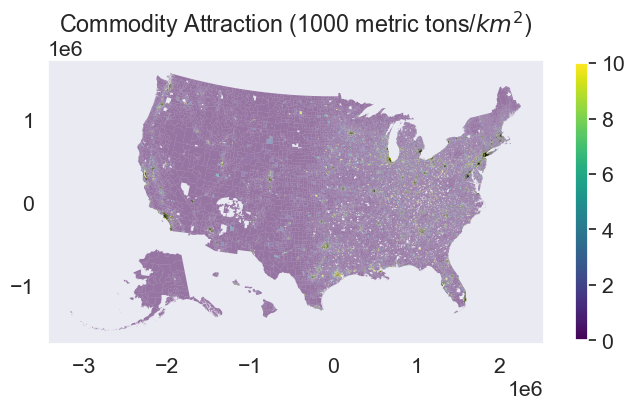

In [19]:
ax = region_map_with_attraction.plot(figsize = (8,6), column = 'attraction_per_area', 
                            alpha = 0.5, legend=True,
                            vmin = 0, vmax = 10,
                            # norm=matplotlib.colors.LogNorm(vmin=region_map_with_attraction.attraction_per_area.min(), 
                            #                                vmax=region_map_with_attraction.attraction_per_area.max()),
                                    cmap='viridis',
                            linewidth=0.01, 
                            legend_kwds = {'shrink': 0.6})
# cx.add_basemap(ax, crs = 'EPSG:4326',source = cx.providers.CartoDB.Positron)
plt.title('Commodity Attraction (1000 metric tons/$km^{2}$)')
ax.grid(False)
plt.savefig(os.path.join(plot_dir, 'region_attraction_allmodes.png'), dpi = 200)

In [20]:
# generate plot by county
from pygris import counties
analysis_year = 2017
us_counties = counties(year = analysis_year)

In [21]:
us_counties = shift_geometry(us_counties)
us_counties.head(5)

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,31,039,00835841,31039,Cuming,Cuming County,06,H1,G4020,None,None,None,A,1477641638,10701538,+41.9158651,-096.7885168,"POLYGON ((-83865.229 505034.281, -83864.472 50..."
1,53,069,01513275,53069,Wahkiakum,Wahkiakum County,06,H1,G4020,None,None,None,A,680956787,61588406,+46.2946377,-123.4244583,"POLYGON ((-2091374.748 1280511.226, -2091836.9..."
2,35,011,00933054,35011,De Baca,De Baca County,06,H1,G4020,None,None,None,A,6016761648,29147345,+34.3592729,-104.3686961,"POLYGON ((-784537.566 -356694.208, -784567.663..."
3,31,109,00835876,31109,Lancaster,Lancaster County,06,H1,G4020,339,30700,None,A,2169252486,22867561,+40.7835474,-096.6886584,"POLYGON ((-76027.445 387911.505, -76027.307 38..."
4,31,129,00835886,31129,Nuckolls,Nuckolls County,06,H1,G4020,None,None,None,A,1489645186,1718484,+40.1764918,-098.0468422,"POLYGON ((-192145.704 292506.586, -192145.672 ..."


In [22]:
us_counties.loc[:, 'area'] = (us_counties.loc[:, 'ALAND'] + us_counties.loc[:, 'AWATER'])/ 1000000
print(firm_by_zone.columns)
firm_attr_by_county = firm_by_zone.groupby('CBPZONE')[['firm_count', 'employment_count']].sum()
firm_attr_by_county = firm_attr_by_county.reset_index()
firm_attr_by_county.loc[:, 'CBPZONE'] = firm_attr_by_county.loc[:, 'CBPZONE'].astype(int)
firm_attr_by_county.rename(columns = {'CBPZONE': 'GEOID'}, inplace = True)
us_counties.loc[:, 'GEOID'] = us_counties.loc[:, 'GEOID'].astype(int)

county_map_with_firm = us_counties.merge(firm_attr_by_county, on='GEOID', how='inner')
county_map_with_firm.loc[:, 'firm_per_area'] = \
county_map_with_firm.loc[:, 'firm_count'] / county_map_with_firm.loc[:, 'area']
county_map_with_firm.loc[:, 'emp_per_area'] = \
county_map_with_firm.loc[:, 'employment_count'] / county_map_with_firm.loc[:, 'area']
county_map_with_firm.head(5)

Index(['MESOZONE', 'firm_count', 'employment_count', 'GEOID', 'FAFID',
       'CBPZONE', 'FAFNAME'],
      dtype='object')


,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,...,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,area,firm_count,employment_count,firm_per_area,emp_per_area
0,31,039,00835841,31039,Cuming,Cuming County,06,H1,G4020,None,...,1477641638,10701538,+41.9158651,-096.7885168,"POLYGON ((-83865.229 505034.281, -83864.472 50...",1488.343176,476,4119.0,0.319819,2.767507
1,53,069,01513275,53069,Wahkiakum,Wahkiakum County,06,H1,G4020,None,...,680956787,61588406,+46.2946377,-123.4244583,"POLYGON ((-2091374.748 1280511.226, -2091836.9...",742.545193,97,617.0,0.130632,0.830926
2,35,011,00933054,35011,De Baca,De Baca County,06,H1,G4020,None,...,6016761648,29147345,+34.3592729,-104.3686961,"POLYGON ((-784537.566 -356694.208, -784567.663...",6045.908993,73,371.0,0.012074,0.061364
3,31,109,00835876,31109,Lancaster,Lancaster County,06,H1,G4020,339,...,2169252486,22867561,+40.7835474,-096.6886584,"POLYGON ((-76027.445 387911.505, -76027.307 38...",2192.120047,8943,179153.0,4.079612,81.725907
4,31,129,00835886,31129,Nuckolls,Nuckolls County,06,H1,G4020,None,...,1489645186,1718484,+40.1764918,-098.0468422,"POLYGON ((-192145.704 292506.586, -192145.672 ...",1491.363670,207,1433.0,0.138799,0.960866


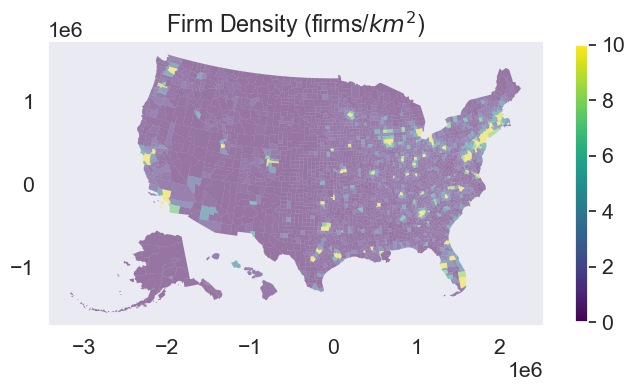

In [23]:
ax = county_map_with_firm.plot(figsize = (8,6), column = 'firm_per_area', 
                           vmin=0, vmax=10, alpha = 0.5, legend=True,
                              cmap='viridis',
                              linewidth=0.01, 
                            legend_kwds = {'shrink': 0.6}, edgecolor='none')
# cx.add_basemap(ax, crs = 'EPSG:4326', source = cx.providers.CartoDB.Positron)
# ax.set_xlim(-125,-62)
# ax.set_ylim(24,50)
ax.grid(False)
plt.title('Firm Density (firms/$km^{2}$)')
plt.savefig(os.path.join(plot_dir, 'county_firm_count.png'), dpi = 300)

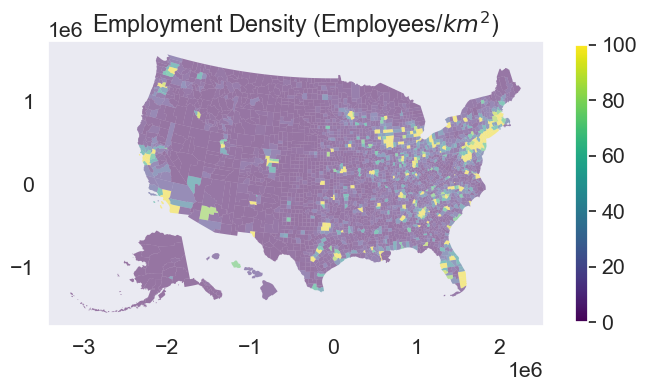

In [24]:
ax = county_map_with_firm.plot(figsize = (8,6), column = 'emp_per_area', 
                           vmin=0, vmax=100, alpha = 0.5, legend=True,
                              cmap='viridis',
                              linewidth=0.01, 
                            legend_kwds = {'shrink': 0.6}, edgecolor='none')
# cx.add_basemap(ax, crs = 'EPSG:4326', source = cx.providers.CartoDB.Positron)
# ax.set_xlim(-125,-62)
# ax.set_ylim(24,50)
ax.grid(False)
plt.title('Employment Density (Employees/$km^{2}$)')
plt.savefig(os.path.join(plot_dir, 'county_emp_count.png'), dpi = 300)

In [25]:
mesozone_to_county = mesozone_id_lookup[['MESOZONE', 'CBPZONE']]
mesozone_to_county.loc[:, 'MESOZONE'] = mesozone_to_county.loc[:, 'MESOZONE'].astype(np.int64)
production_by_county = pd.merge(production_in_region, mesozone_to_county, 
                               on = 'MESOZONE', how = 'left')
production_by_county = production_by_county.groupby('CBPZONE')[['ShipmentLoad']].sum()
production_by_county = production_by_county.reset_index()
production_by_county.loc[:, 'CBPZONE'] = production_by_county.loc[:, 'CBPZONE'].astype(int)
production_by_county.rename(columns = {'CBPZONE': 'GEOID'}, inplace = True)
production_by_county.head(5)

attraction_by_county = pd.merge(attraction_in_region, mesozone_to_county, 
                               on = 'MESOZONE', how = 'left')
attraction_by_county = attraction_by_county.groupby('CBPZONE')[['ShipmentLoad']].sum()
attraction_by_county = attraction_by_county.reset_index()
attraction_by_county.loc[:, 'CBPZONE'] = attraction_by_county.loc[:, 'CBPZONE'].astype(int)
attraction_by_county.rename(columns = {'CBPZONE': 'GEOID'}, inplace = True)
attraction_by_county.head(5)

,GEOID,ShipmentLoad
0,1001,786.626449
1,1003,10139.252570
2,1005,902.190011
3,1007,490.585235
4,1009,670.154448


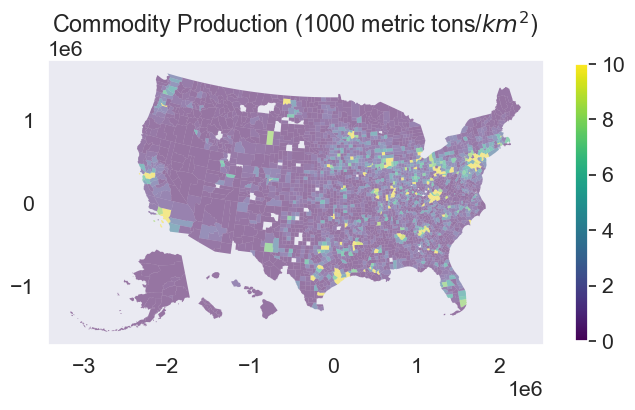

In [26]:
county_map_with_production = \
us_counties.merge(production_by_county, on='GEOID', how='inner')
county_map_with_production.loc[:, 'production_per_area'] = \
county_map_with_production.loc[:, 'ShipmentLoad'] * 0.907185/ \
county_map_with_production.loc[:, 'area']
# sf_map_with_firm.loc[:, 'emp_per_area'] = sf_map_with_firm.loc[:, 'employment_count'] / sf_map_with_firm.loc[:, 'area']
ax = county_map_with_production.plot(figsize = (8,6), column = 'production_per_area', 
                            alpha = 0.5, legend=True,
                            vmin = 0, vmax = 10,
                            # norm=matplotlib.colors.LogNorm(vmin=region_map_with_production.production_per_area.min(), 
                            #                                vmax=region_map_with_production.production_per_area.max()),
                            cmap='viridis',
                            linewidth=0.01, 
                            legend_kwds = {'shrink': 0.6})
# cx.add_basemap(ax, crs = 'EPSG:4326',source = cx.providers.CartoDB.Positron)

ax.grid(False)
plt.title('Commodity Production (1000 metric tons/$km^{2}$)')
plt.savefig(os.path.join(plot_dir, 'county_production_allmodes.png'), dpi = 300)

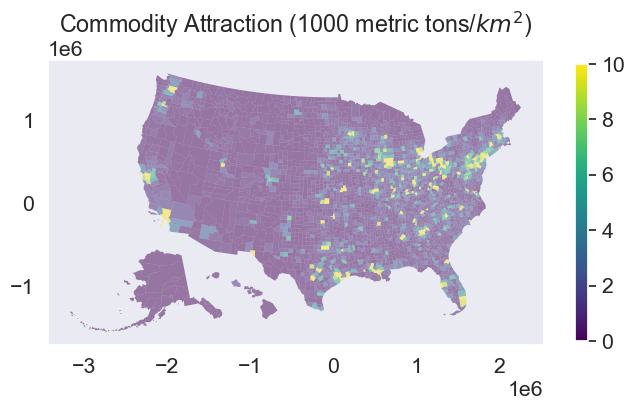

In [27]:
county_map_with_attraction = \
us_counties.merge(attraction_by_county, on='GEOID', how='inner')
county_map_with_attraction.loc[:, 'attraction_per_area'] = \
county_map_with_attraction.loc[:, 'ShipmentLoad'] * 0.907185/ \
county_map_with_attraction.loc[:, 'area']
# sf_map_with_firm.loc[:, 'emp_per_area'] = sf_map_with_firm.loc[:, 'employment_count'] / sf_map_with_firm.loc[:, 'area']
ax = county_map_with_attraction.plot(figsize = (8,6), column = 'attraction_per_area', 
                            alpha = 0.5, legend=True,
                            vmin = 0, vmax = 10,
                            # norm=matplotlib.colors.LogNorm(vmin=region_map_with_production.production_per_area.min(), 
                            #                                vmax=region_map_with_production.production_per_area.max()),
                            cmap='viridis',
                            linewidth=0.01, 
                            legend_kwds = {'shrink': 0.6})
# cx.add_basemap(ax, crs = 'EPSG:4326',source = cx.providers.CartoDB.Positron)

ax.grid(False)
plt.title('Commodity Attraction (1000 metric tons/$km^{2}$)')
plt.savefig(os.path.join(plot_dir, 'county_attraction_allmodes.png'), dpi = 300)